# Surrogate Ray Tracing Model: Using Optiland and PyTorch

### Introduction
In this notebook, we will demonstrate how to create a surrogate ray-tracing model for a lens system using Optiland for data generation and PyTorch for model training. Specifically, we will:

1. Model a double Gauss lens system in Optiland.
2. Build a PyTorch dataloader to randomly generate and trace rays through the system. Inputs are reported as ray starting positions and outputs are the (x, y) intersections at the image plane.
3. Train a PyTorch-based neural network to predict intersection points based on ray parameters.
4. Assess performance of PyTorch model and compare to direct ray-traced result.
5. Compare the speed of the surrogate model with the analytical ray tracer implemented in Optiland.

By the end of this notebook, you will understand how to combine physics-based modeling with machine learning to accelerate computational tasks.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from optiland.samples.objectives import DoubleGauss

## Step 1: Setting Up the Lens System with Optiland

We will model a double Gauss lens system in Optiland. Below is the code to define and view the lens system.

In [2]:
lens = DoubleGauss()

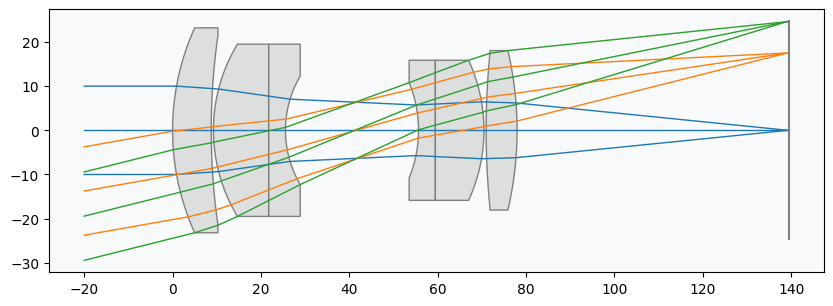

In [3]:
lens.draw()

Check that maximum ray height on the image surface by tracing through the max normalized field coordinate and reporting the largest y intersection point:

In [4]:
rays = lens.trace(Hx=0, Hy=1, distribution='line_y', wavelength=0.5876, num_rays=3)
print(f'Maximum radial position: {np.max(rays.y):.3f} mm')

Maximum radial position: 24.714 mm


## Step 2: Data generation

We will first create a few helper functions:
- normalize and denormalize functions to bring x and y intersection points within the range (0, 1)
- function to generate random normalized field and pupil coordinates, which will be used for ray tracing
- function to generate random rays and trace them through a lens system

In [5]:
def normalize(x, max_val=25.72):
    """Helper function to normalize the output values."""
    return x / max_val

In [6]:
def denormalize(x, max_val=25.72):
    """Helper function to denormalize the output values."""
    return x * max_val

In [7]:
def generate_random_coords(batch_size):
    """Generate random normalized field and pupil coordinates."""
    # get random field coordinates (Hx, Hy)
    theta = np.random.uniform(0, 2 * np.pi, size=batch_size)
    r = np.sqrt(np.random.uniform(0, 1, size=batch_size))
    Hx = r * np.cos(theta)
    Hy = r * np.sin(theta)

    # get random pupil coordinates (Px, Py)
    theta = np.random.uniform(0, 2 * np.pi, size=batch_size)
    r = np.sqrt(np.random.uniform(0, 1, size=batch_size))
    Px = r * np.cos(theta)
    Py = r * np.sin(theta)

    return Hx, Hy, Px, Py

In [8]:
def trace_random_rays(lens, batch_size):
    """Trace random rays through the lens system."""
    # get random field and pupil coordinates
    Hx, Hy, Px, Py = generate_random_coords(batch_size)

    # define fixed wavelength
    wavelength = np.full(batch_size, 0.5876)

    # trace rays and return
    rays_out = lens.trace_generic(Hx, Hy, Px, Py, wavelength)

    # normalize x and y coordinates based on max image height
    rays_out.x = normalize(rays_out.x)
    rays_out.y = normalize(rays_out.y)
    
    return Hx, Hy, Px, Py, rays_out

### Dataset definition

A PyTorch Dataset is a fundamental building block for creating data pipelines in PyTorch. The primary purpose of a Dataset is to provide an interface to access and manipulate data samples and their corresponding labels or targets. For our purposes, the data samples are the ray input coordinates and the targets are the ray intersection points at the image plane.

Here we define a PyTorch dataset that will:
1. Generate random rays and trace them through the system
2. Prepare the model inputs by concatenating the field and pupil coordinates
3. Prepare the model outputs by concatenating the ray (x, y) intersection points at the image plane
4. Convert input and output arrays into torch tensors and return them

In [9]:
class BatchRayTracingDataset(Dataset):
    def __init__(self, lens, num_rays, batch_size, seed=None):
        """
        Custom PyTorch dataset for batch-based ray tracing using Optiland.

        Args:
            lens (optiland.optic.Optic): The lens system to trace rays through.
            num_rays (int): Total number of rays in the dataset.
            batch_size (int): Number of rays to trace in a single batch.
            seed (int, optional): Random seed for reproducibility. Defaults to None.
        """
        self.lens = lens
        self.num_rays = num_rays
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(num_rays / batch_size))
        if seed is not None:
            np.random.seed(seed)

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        """
        Generates a batch of rays and traces them through the lens system.
        """
        # Determine the size of the batch
        batch_start = idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, self.num_rays)
        batch_size = batch_end - batch_start

        # Trace random rays through the lens
        Hx, Hy, Px, Py, rays_out = trace_random_rays(self.lens, batch_size)

        # Prepare inputs (field and pupil coordinates)
        inputs = np.column_stack((Hx, Hy, Px, Py))

        # Prepare outputs (intersection points)
        outputs = np.column_stack((rays_out.x, rays_out.y))

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(outputs, dtype=torch.float32)

# Step 3: Training the surrogate model using PyTorch

We will use a simple fully connected neural network to predict the intersection points based on ray pupil and field coordinates.

The network will take four inputs: the field coordinates (Hx, Hy) and the pupil coordinates (Px, Py). The output will be the predicted intersection points (x, y) at the image plane. The network architecture consists of three hidden layers with 128 neurons each, using ReLU activation functions, and an output layer with 2 neurons.

In [10]:
class RayTracerSurrogate(nn.Module):
    def __init__(self):
        super(RayTracerSurrogate, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output is (intersection_x, intersection_y)
        )
    
    def forward(self, x):
        return self.fc(x)

This script will train on the GPU, if it's available.

Note: Ensure that you have installed PyTorch with CUDA support to be able to train on the GPU.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


### Define the dataset and dataloader for model training

During training, we will use 1 million rays per epoch and a ray batch size of 100,000.

This means that for each epoch (a complete pass through the entire dataset), the model will process 1 million rays.

The ray batch size of 100,000 indicates that the model will process the rays in smaller groups or batches of 100,000 rays at a time. This is done to manage memory usage and computational efficiency, as processing the entire dataset at once may be impractical or impossible due to resource constraints.

By dividing the dataset into batches, the model can be trained iteratively, updating its parameters after each batch, which helps in faster convergence and better generalization.

In [12]:
num_rays = 1_000_000  # Total rays
batch_size = 100_000  # Number of rays per batch
dataset = BatchRayTracingDataset(lens, num_rays, batch_size, seed=42)

In [13]:
dataloader = DataLoader(dataset, batch_size=1)

### Instantiate the model, loss function, and optimizer

We instantiate the model, define the loss function as Mean Squared Error (MSE), and use the Adam optimizer with a learning rate of 0.001. The model is moved to the GPU if available.

In [14]:
model = RayTracerSurrogate().to(device)  # put model onto GPU (if available)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train the model over 50 epochs

- **Training loop**: We train the model over 50 epochs. For each epoch, we:
    - Initialize the total loss for the epoch.
    - Iterate over the batches of data from the dataloader.
    - Move the batch inputs and outputs to the GPU if available.
    - Perform a forward pass to get the model predictions.
    - Compute the loss between the predictions and the actual outputs.
    - Perform a backward pass to compute the gradients.
    - Update the model parameters using the optimizer.
    - Accumulate the loss for the epoch.
    - Print the loss every 10 epochs to monitor the training progress.

In [15]:
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for batch_inputs, batch_outputs in dataloader:
        batch_inputs, batch_outputs = batch_inputs.to(device), batch_outputs.to(device)
        optimizer.zero_grad()
        predictions = model(batch_inputs)
        loss = criterion(predictions, batch_outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.5f}")

Epoch 10/50, Loss: 0.00197
Epoch 20/50, Loss: 0.00074
Epoch 30/50, Loss: 0.00047
Epoch 40/50, Loss: 0.00034
Epoch 50/50, Loss: 0.00027


The resulting mean squared error (MSE) is 0.00027, which corresponds to 7 µm when denormalized. This accuracy is reasonable, but may not be sufficient for many applications.

# Step 4: Compare model performance to the direct ray-traced result

We start by creating a helper function to generate the intersections predicted by the neural network, as well as the ground truth intersection points based on ray tracing.

In [16]:
def compare_model_to_truth(model, lens, num_rays=1000):
    # Trace random rays through the lens
    Hx, Hy, Px, Py, rays_out = trace_random_rays(lens, num_rays)

    # Prepare inputs (field and pupil coordinates)
    inputs = np.column_stack((Hx, Hy, Px, Py))

    # Predict the intersection points using the model
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(inputs_tensor).cpu().numpy()

    pred_x = denormalize(predictions[:, 0])
    pred_y = denormalize(predictions[:, 1])

    true_x = denormalize(rays_out.x)
    true_y = denormalize(rays_out.y)

    return pred_x, pred_y, true_x, true_y

Compare the model predictions to the ground truth for 25 random samples.

In [17]:
pred_x, pred_y, true_x, true_y = compare_model_to_truth(model, lens, num_rays=25)

Plotting the predicted points versus the ground truth points indicates the model result compares reasonably well to the ground truth result.

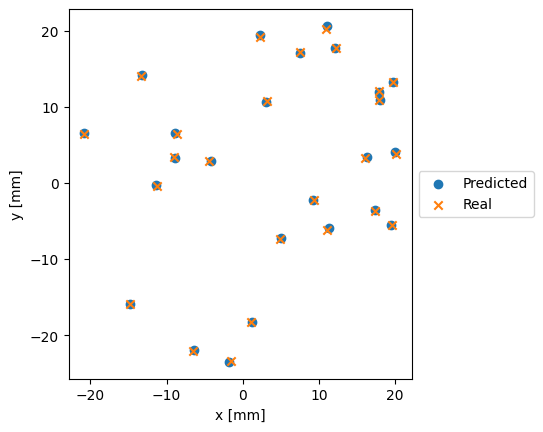

In [18]:
plt.scatter(pred_x, pred_y, label='Predicted', marker='o')
plt.scatter(true_x, true_y, label='Real', marker='x')

plt.axis('image')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We plot the distribution of errors between the points. This shows that the error is generally less than about 0.3 mm, but occasionally reaches values up to approximately 0.5 mm. If we were to use a more complex neural network, we could extract more complexities and nuances of the data, and the accuracy would likely improve.

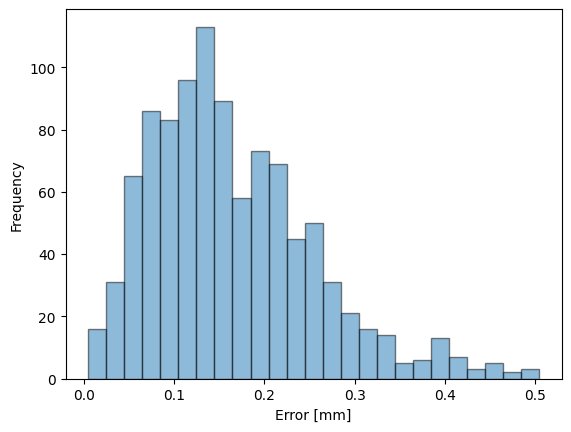

In [19]:
pred_x, pred_y, true_x, true_y = compare_model_to_truth(model, lens, num_rays=1000)

error = np.sqrt((pred_x - true_x)**2 + (pred_y - true_y)**2)
plt.hist(error, edgecolor='black', bins=25, alpha=0.5)
plt.xlabel('Error [mm]')
plt.ylabel('Frequency')
plt.show()

# Step 5: Measure Inference Speed

In this step, we will measure the inference speed of the trained neural network model. The inference speed is a critical factor in evaluating the performance of the surrogate model, especially when compared to traditional ray tracing methods. We will:

1. Generate a large number of random rays.
2. Perform a forward pass through the neural network model multiple times.
3. Measure the time taken for these forward passes.
4. Calculate the average time per forward pass and the effective speed in terms of ray-surfaces per second.

This will help us understand the computational efficiency of the surrogate model and its potential advantages over conventional ray tracing techniques.

In [20]:
num_rays = 1_000_000
Hx, Hy, Px, Py = generate_random_coords(num_rays)

sample_input = torch.tensor(np.column_stack((Hx, Hy, Px, Py)), dtype=torch.float32).to(device)

# Warm-up the GPU by running the model a few times
for _ in range(10):
    _ = model(sample_input)

# Measure the time taken for a forward pass
num_its = 100

start_time = time.time()
with torch.no_grad():  # Disable gradient calculation for inference
    for _ in range(num_its):
        _ = model(sample_input)
end_time = time.time()

In [21]:
avg_time = (end_time - start_time) / num_its  # Average time per forward pass

num_surfaces = len(lens.surface_group.surfaces)  # Number of surfaces in the lens system
rss = num_rays * num_surfaces / avg_time / 1e9  # Ray-surfaces per second

print(f'Neural Network Inference Speed: {rss:.1f} billion ray-surfaces per second')

Neural Network Inference Speed: 77.5 billion ray-surfaces per second


The final _effective_ speed of the model is **77.5 billion ray-surfaces per second**. We are not actually ray tracing here, so this metric may not be considered fully representative. Nonetheless, this allows for a direct comparison to the ray-traced result. Compare this result to a typical raytrace speed of approximately 5 million ray-surfaces per second for the double Gauss lens in Optiland.

# Conclusions

- This notebook demonstrated how to create a surrogate ray tracing model using Optiland for data generation and PyTorch for model training.
- We modeled a double Gauss lens system and generated ray tracing data.
- A PyTorch-based neural network was trained to predict intersection points based on ray field and pupil coordinates.
- The model's performance was assessed and compared to direct ray-traced results, showing reasonable accuracy.
- The inference speed of the surrogate model was measured, demonstrating significant computational efficiency improvements over traditional ray tracing methods.